In [2]:
import sys
from PIL import Image
sys.path.append('/elpv-dataset-master/utils')
import numpy as np
from elpv_reader import load_dataset
import torch
import cv2
from torchvision import transforms
import random

from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet34
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load the dataset
images, proba, types = load_dataset()

unique, counts = np.unique(proba, return_counts=True)
proba_distribution = dict(zip(unique, counts))
print("Original probability distribution:", proba_distribution)
print("Original image size (train):", images.shape)

train_acc_history = []
test_acc_history = []
loss_history = []


train_acc_history = []
test_acc_history = []
loss_history = []

def train_transform(image):
    # Check if the image is already grayscale (1 channel)
    if len(image.shape) == 3 and image.shape[2] > 1:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Convert NumPy array to PIL Image
    image = Image.fromarray((image * 255).astype(np.uint8))

    # Random horizontal flipping with a 50% probability
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # Convert PIL Image to NumPy array
    image = np.array(image) / 255.0

    # Random rotation between -10 and 10 degrees
    angle = random.uniform(-10, 10)
    center = (image.shape[1] / 2, image.shape[0] / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    # Random scaling between 0.8 and 1.2 times the original size
    scale = random.uniform(0.8, 1.2)
    image = cv2.resize(image, None, fx=scale, fy=scale)

    # Random translation
    max_translation_x = image.shape[1] * 0.1  # Allowing up to 10% translation
    max_translation_y = image.shape[0] * 0.1
    translation_x = random.uniform(-max_translation_x, max_translation_x)
    translation_y = random.uniform(-max_translation_y, max_translation_y)
    translation_matrix = np.array([[1, 0, translation_x], [0, 1, translation_y]], dtype=np.float32)
    image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))

    # Ensure the image stays within the original size (crop if necessary)
    image = image[:224, :224]

    # Convert back to the same type as input and normalize
    return image

def test_transform(image):
    # Check if the image is already grayscale (1 channel)
    if len(image.shape) == 3 and image.shape[2] > 1:        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    image = cv2.resize(image, (224, 224))
    return image



def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()  

    with torch.no_grad():  
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Split the data into training and testing sets
def proba_to_label(proba):
    if proba == 0:
        return 0
    elif proba == 0.3333333333333333:
        return 1
    elif proba == 0.6666666666666666:
        return 2
    else:  # proba == 1
        return 3

y_labels = [proba_to_label(proba) for proba in proba]

# Count the number of occurrences for each label
label_counts = {label: y_labels.count(label) for label in set(y_labels)}
print("Total counts per class:", label_counts)

# Split the dataset into training and test sets, ensuring similar distribution of classes in both
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(images, y_labels, types, test_size=0.25, stratify=y_labels)

# Count the number of occurrences for each label in the training and test sets
train_label_counts = {label: y_train.count(label) for label in set(y_train)}
test_label_counts = {label: y_test.count(label) for label in set(y_test)}
print("Training set counts per class:", train_label_counts)
print("Test set counts per class:", test_label_counts)

# Convert the class labels into PyTorch Tensor format
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# Convert NumPy arrays to PyTorch tensors without changing the data type (float32)
X_train = torch.stack([torch.tensor(train_transform(image), dtype=torch.float32).unsqueeze(0) for image in X_train])
X_test = torch.stack([torch.tensor(test_transform(image), dtype=torch.float32).unsqueeze(0) for image in X_test])


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(X_train[0].shape)

# Find indices for monocrystalline and polycrystalline in the test set
mono_indices_test = [i for i, t in enumerate(types_test) if t == 'mono']
poly_indices_test = [i for i, t in enumerate(types_test) if t == 'poly']

# Create separate test sets for monocrystalline and polycrystalline
X_test_mono = X_test[mono_indices_test]
y_test_mono = y_test[mono_indices_test]
X_test_poly = X_test[poly_indices_test]
y_test_poly = y_test[poly_indices_test]

# Convert each numpy array in the list to a PyTorch tensor, then stack them
X_test_mono = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_mono])
X_test_poly = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_poly])


y_test_mono = torch.tensor(y_test_mono, dtype=torch.long)
y_test_poly = torch.tensor(y_test_poly, dtype=torch.long)


# Create separate test datasets and DataLoaders for monocrystalline and polycrystalline
test_dataset_mono = TensorDataset(X_test_mono, y_test_mono)
test_dataset_poly = TensorDataset(X_test_poly, y_test_poly)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=32, shuffle=False)
test_loader_poly = DataLoader(test_dataset_poly, batch_size=32, shuffle=False)


# Build the model
model = resnet34(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  
model.fc = nn.Linear(model.fc.in_features, 4)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Train the model
model = model.float()
best_model_wts = None
best_acc = 0.0
epochs_no_improve = 0
patience = 5
early_stop_threshold = 5 


for epoch in range(20):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    # Calculate accuracies
    train_acc = calculate_accuracy(model, train_loader)
    test_acc = calculate_accuracy(model, test_loader)
    
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    loss_history.append(running_loss / len(train_loader))
    print(f"Epoch {epoch + 1}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}, Best Acc: {best_acc:.2f}, No Improve: {epochs_no_improve}")

    scheduler.step(running_loss)

    # Save the best model
    # Save the best model and handle early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = model.state_dict().copy()
        epochs_no_improve = 0
    else:
        if epoch >= early_stop_threshold:  
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered based on accuracy after {epoch + 1} epochs!")
                model.load_state_dict(best_model_wts)
                break

def evaluate_model(model, loader):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])  # Ensure 4x4 matrix
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, acc, f1
# Test the model
model.eval()
cm_all, acc_all, f1_all = evaluate_model(model, test_loader)
cm_mono, acc_mono, f1_mono = evaluate_model(model, test_loader_mono)
cm_poly, acc_poly, f1_poly = evaluate_model(model, test_loader_poly)

# Print results
print('All Test Cells:')
print('Confusion Matrix:')
print(cm_all)
print(f'Accuracy: {acc_all:.2f}')
print(f'F1 Score: {f1_all:.2f}')

print('\nMonocrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_mono)
print(f'Accuracy: {acc_mono:.2f}')
print(f'F1 Score: {f1_mono:.2f}')

print('\nPolycrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_poly)
print(f'Accuracy: {acc_poly:.2f}')
print(f'F1 Score: {f1_poly:.2f}')

epochs = range(1, len(train_acc_history) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, test_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

torch.Size([1, 224, 224])


<ipython-input-2-aef737223b61>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_mono = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_mono])
<ipython-input-2-aef737223b61>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_poly = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_poly])
<ipython-input-2-aef737223b61>:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_mono = torch.tensor(y_test_mono, dtype=torch.long)
<ipython-input-2-aef737223b61>:142: UserWarning: To co

Epoch 1, Train Acc: 68.09, Test Acc: 42.53, Best Acc: 0.00, No Improve: 0
Epoch 2, Train Acc: 68.60, Test Acc: 42.53, Best Acc: 42.53, No Improve: 0
Epoch 3, Train Acc: 69.16, Test Acc: 42.53, Best Acc: 42.53, No Improve: 0
Epoch 4, Train Acc: 69.87, Test Acc: 42.53, Best Acc: 42.53, No Improve: 0
Epoch 5, Train Acc: 62.60, Test Acc: 58.84, Best Acc: 42.53, No Improve: 0
Epoch 6, Train Acc: 70.48, Test Acc: 42.53, Best Acc: 58.84, No Improve: 0
Epoch 7, Train Acc: 72.46, Test Acc: 42.53, Best Acc: 58.84, No Improve: 1
Epoch 8, Train Acc: 69.56, Test Acc: 42.53, Best Acc: 58.84, No Improve: 2
Epoch 9, Train Acc: 48.22, Test Acc: 42.53, Best Acc: 58.84, No Improve: 3
Early stopping triggered based on accuracy after 9 epochs!


All Test Cells:
Confusion Matrix:
[[  0   0   0 377]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0 279]]
Accuracy: 0.43
F1 Score: 0.25

Monocrystalline Test Cells:
Confusion Matrix:
[[  0   0   0 151]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0 122]]
Accuracy: 0.45
F1 Score: 0.28

Polycrystalline Test Cells:
Confusion Matrix:
[[  0   0   0 226]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0 157]]
Accuracy: 0.41
F1 Score: 0.24


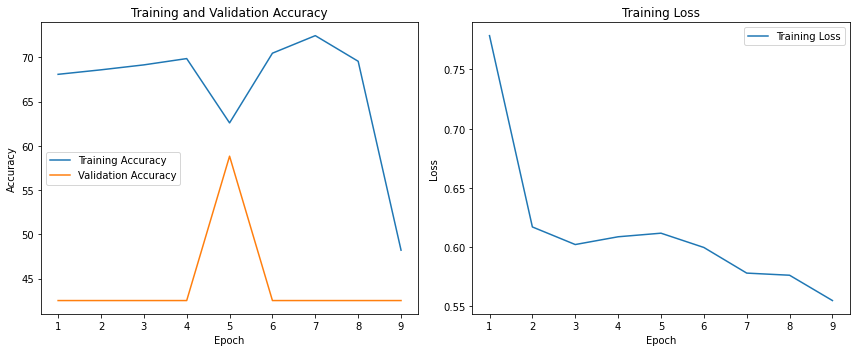

In [3]:

def evaluate_model(model, loader):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])  # Ensure 4x4 matrix
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, acc, f1
# Test the model
model.eval()
cm_all, acc_all, f1_all = evaluate_model(model, test_loader)
cm_mono, acc_mono, f1_mono = evaluate_model(model, test_loader_mono)
cm_poly, acc_poly, f1_poly = evaluate_model(model, test_loader_poly)

# Print results
print('All Test Cells:')
print('Confusion Matrix:')
print(cm_all)
print(f'Accuracy: {acc_all:.2f}')
print(f'F1 Score: {f1_all:.2f}')

print('\nMonocrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_mono)
print(f'Accuracy: {acc_mono:.2f}')
print(f'F1 Score: {f1_mono:.2f}')

print('\nPolycrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_poly)
print(f'Accuracy: {acc_poly:.2f}')
print(f'F1 Score: {f1_poly:.2f}')

epochs = range(1, len(train_acc_history) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, test_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
import sys
from PIL import Image
sys.path.append('/elpv-dataset-master/utils')
import numpy as np
from elpv_reader import load_dataset
import torch
import cv2
from torchvision import transforms
import random

from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
images, proba, types = load_dataset()

unique, counts = np.unique(proba, return_counts=True)
proba_distribution = dict(zip(unique, counts))
print("Original probability distribution:", proba_distribution)
print("Original image size (train):", images.shape)

train_acc_history = []
test_acc_history = []
loss_history = []




Original probability distribution: {0.0: 1508, 0.3333333333333333: 295, 0.6666666666666666: 106, 1.0: 715}
Original image size (train): (2624, 300, 300)


In [6]:
from imblearn.over_sampling import SMOTE

train_acc_history = []
test_acc_history = []
loss_history = []
print(images.shape)

def train_transform(image):
    
    image = cv2.resize(image, (224, 224))

    # Convert back to the same type as input and normalize
    return image

def test_transform(image):
    # Check if the image is already grayscale (1 channel)
    if len(image.shape) == 3 and image.shape[2] > 1:        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    image = cv2.resize(image, (224, 224))
    return image



def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()  

    with torch.no_grad():  
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Split the data into training and testing sets
def proba_to_label(proba):
    if proba == 0:
        return 0
    elif proba == 0.3333333333333333:
        return 1
    elif proba == 0.6666666666666666:
        return 2
    else:  # proba == 1
        return 3
from imblearn.over_sampling import SMOTE
import numpy as np
from collections import Counter

def oversample(X, y, types):
    

    # Create a SMOTE object
    smote = SMOTE()

    # Perform SMOTE resampling on the feature matrix and target array
    X_over, y_over = smote.fit_resample(X, y)
    
    types_over = []
    counts = Counter(y_over)  # Get the count of each class in the oversampled target array
    for class_type in np.unique(y):
        class_indices = [i for i, x in enumerate(y_over) if x == class_type]  # Indices of the current class type in y_over
        required_samples = counts[class_type]  # The number of samples needed for the current class type after oversampling
        original_indices = [i for i, x in enumerate(y) if x == class_type]  # Indices of the current class type in the original y array
        
        # If we have original samples, replicate them to match the oversampled count
        if original_indices:
            sampled_indices = np.random.choice(original_indices, required_samples, replace=True)  # Randomly choose samples with replacement
            types_over.extend(types[sampled_indices])
        else:
            # If there are no original samples for the class, we need a fallback strategy
            # For example, we can set the type to the most common type or assign a special value
            most_common_type = Counter(types).most_common(1)[0][0]
            types_over.extend([most_common_type] * required_samples)

    # Convert types_over to a numpy array
    types_over = np.array(types_over)

    return X_over, y_over, types_over





from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'proba_to_label' is a function that converts probabilities to a label
y_labels = [proba_to_label(proba) for proba in proba]

# Count each unique label's occurrence
label_counts = {label: y_labels.count(label) for label in set(y_labels)}
print("Total counts per class:", label_counts)

# Reshape images to 2D for SMOTE
num_images, height, width = images.shape
images_reshaped = images.reshape(num_images, -1)

# Apply SMOTE
smote = SMOTE()
X_over, y_labels_over = smote.fit_resample(images_reshaped, y_labels)

# After oversampling, reshape the images back to the original shape
X_over_reshaped = X_over.reshape(-1, height, width)

# Now you need to construct 'types_over'. This part needs careful attention.
# Since SMOTE creates new samples, we cannot simply repeat the 'types'.
# Here's a simple way to do it: for each new sample in 'y_over' that was not in the original 'y_labels',
# we randomly assign a 'type' from the original 'types' corresponding to the same class.

# Find the indices of the added samples
new_indices = [i for i in range(len(y_labels_over)) if i >= len(y_labels)]

# Initialize types_over with the original types
types_over = types.tolist()

# Append types for the new, oversampled indices
for i in new_indices:
    # Get the label of the new sample
    label = y_labels_over[i]
    
    # Get the indices of the original samples with the same label
    original_indices = [j for j, l in enumerate(y_labels) if l == label]
    
    # Randomly choose a type from the original samples of the same label
    chosen_type = types[np.random.choice(original_indices)]
    
    # Append this type to types_over
    types_over.append(chosen_type)

# Ensure that 'types_over' is now a numpy array
types_over = np.array(types_over)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(
    X_over_reshaped, y_labels_over, types_over, test_size=0.25, stratify=y_labels_over
)

# Count the number of occurrences for each label in the training and test sets using numpy
# 'unique' contains the unique labels, and 'counts' contains the count for each label
unique, counts = np.unique(y_train, return_counts=True)
train_label_counts = dict(zip(unique, counts))  # Creating a dictionary from labels and their counts for training set

unique, counts = np.unique(y_test, return_counts=True)
test_label_counts = dict(zip(unique, counts))  # Creating a dictionary from labels and their counts for test set

print("Training set counts per class:", train_label_counts)
print("Test set counts per class:", test_label_counts)

# Convert the class labels into PyTorch Tensor format
# This is necessary for using these labels in PyTorch-based machine learning models
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Convert NumPy arrays to PyTorch tensors without changing the data type (float32)
X_train = torch.stack([torch.tensor(train_transform(image), dtype=torch.float32).unsqueeze(0) for image in X_train])
X_test = torch.stack([torch.tensor(test_transform(image), dtype=torch.float32).unsqueeze(0) for image in X_test])


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(X_train[0].shape)

# Find indices for monocrystalline and polycrystalline in the test set
mono_indices_test = [i for i, t in enumerate(types_test) if t == 'mono']
poly_indices_test = [i for i, t in enumerate(types_test) if t == 'poly']

# Create separate test sets for monocrystalline and polycrystalline
X_test_mono = X_test[mono_indices_test]
y_test_mono = y_test[mono_indices_test]
X_test_poly = X_test[poly_indices_test]
y_test_poly = y_test[poly_indices_test]

# Convert each numpy array in the list to a PyTorch tensor, then stack them
X_test_mono = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_mono])
X_test_poly = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_poly])


y_test_mono = torch.tensor(y_test_mono, dtype=torch.long)
y_test_poly = torch.tensor(y_test_poly, dtype=torch.long)


# Create separate test datasets and DataLoaders for monocrystalline and polycrystalline
test_dataset_mono = TensorDataset(X_test_mono, y_test_mono)
test_dataset_poly = TensorDataset(X_test_poly, y_test_poly)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=32, shuffle=False)
test_loader_poly = DataLoader(test_dataset_poly, batch_size=32, shuffle=False)


(2624, 300, 300)
Total counts per class: {0: 1508, 1: 295, 2: 106, 3: 715}
Training set counts per class: {0: 1131, 1: 1131, 2: 1131, 3: 1131}
Test set counts per class: {0: 377, 1: 377, 2: 377, 3: 377}
torch.Size([1, 224, 224])


<ipython-input-6-84cef0aed292>:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_mono = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_mono])
<ipython-input-6-84cef0aed292>:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_poly = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_poly])
<ipython-input-6-84cef0aed292>:193: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_mono = torch.tensor(y_test_mono, dtype=torch.long)
<ipython-input-6-84cef0aed292>:194: UserWarning: To co

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from sklearn.ensemble import RandomForestClassifier

class FeatureExtractor(nn.Module):
    def __init__(self, model, num_features, num_classes):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # Remove the last layer
        self.classifier = nn.Linear(num_features, num_classes)  # Add a new classification layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)  # Pass through classifier
        return x

# Determine num_features, which is the number of output features from the last convolutional layer of ResNet
num_features = 512
num_classes = 4  # Number of classes in your dataset
model = resnet34(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Freezing parameters of certain layers
for param in model.parameters():
    param.requires_grad = False

# Re-enable gradients for the last few layers
for param in model.layer4.parameters():
    param.requires_grad = True

# Modify the model to extract features
feature_extractor = FeatureExtractor(model, num_features, num_classes).float()

# Train the neural network to extract features
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

def extract_features(loader, feature_extractor):
    features = []
    labels = []
    with torch.no_grad():
        for data in loader:
            inputs, labels_batch = data
            inputs = inputs.float()
            features_batch = feature_extractor(inputs)
            features.append(features_batch)
            labels.append(labels_batch)
    return torch.cat(features).numpy(), torch.cat(labels).numpy()


for epoch in range(10):
    feature_extractor.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.float()
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        
        # The outputs here will be the final classification outputs
        outputs = feature_extractor(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    # Scheduler step
    scheduler.step(running_loss)


In [16]:
train_features, train_labels = extract_features(train_loader, feature_extractor)

rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def evaluate_model_with_rf(feature_extractor, rf_classifier, loader):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            features = feature_extractor(images)
            predictions = rf_classifier.predict(features.numpy())
            y_pred.extend(predictions)
            y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])  # Ensure 4x4 matrix
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, acc, f1

# test
cm_all, acc_all, f1_all = evaluate_model_with_rf(feature_extractor, rf, test_loader)
cm_mono, acc_mono, f1_mono = evaluate_model_with_rf(feature_extractor, rf, test_loader_mono)
cm_poly, acc_poly, f1_poly = evaluate_model_with_rf(feature_extractor, rf, test_loader_poly)

# print the result 
print('All Test Cells:')
print('Confusion Matrix:')
print(cm_all)
print(f'Accuracy: {acc_all:.2f}')
print(f'F1 Score: {f1_all:.2f}')

print('\nMonocrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_mono)
print(f'Accuracy: {acc_mono:.2f}')
print(f'F1 Score: {f1_mono:.2f}')

print('\nPolycrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_poly)
print(f'Accuracy: {acc_poly:.2f}')
print(f'F1 Score: {f1_poly:.2f}')




All Test Cells:
Confusion Matrix:
[[316  27   8  26]
 [ 34 245  56  42]
 [ 12  25 305  35]
 [ 40  34  46 257]]
Accuracy: 0.74
F1 Score: 0.74

Monocrystalline Test Cells:
Confusion Matrix:
[[125   8   3   6]
 [ 17 107  19  20]
 [ 10  18 162  27]
 [ 19  17  20 120]]
Accuracy: 0.74
F1 Score: 0.73

Polycrystalline Test Cells:
Confusion Matrix:
[[181  19   4  31]
 [ 17 141  34  22]
 [  3   6 139  12]
 [ 19  20  21 141]]
Accuracy: 0.74
F1 Score: 0.74


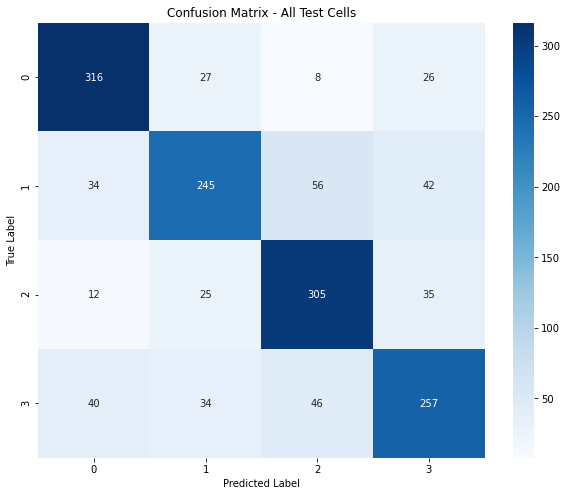

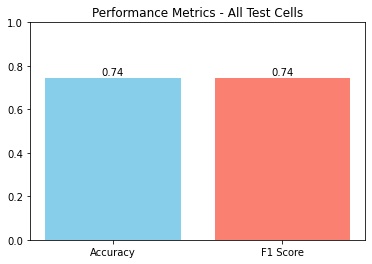

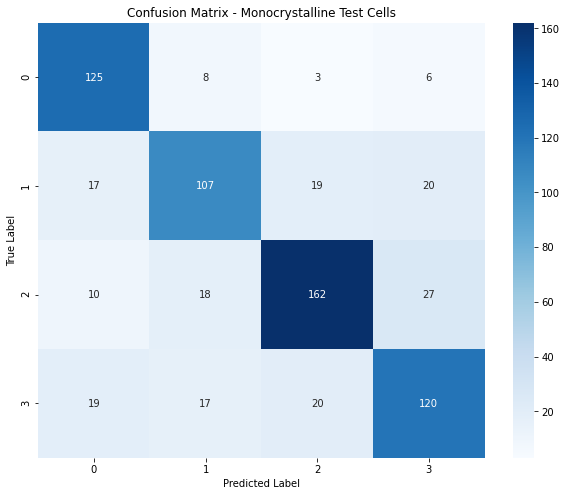

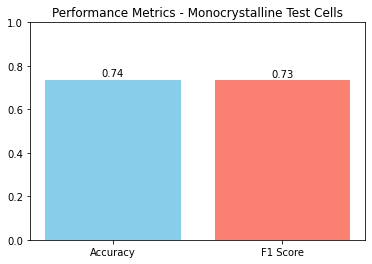

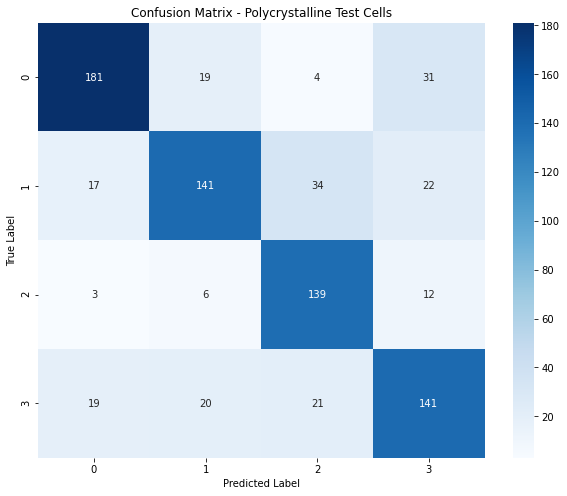

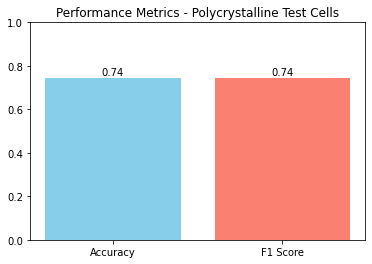

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming cm_all, cm_mono, cm_poly are numpy arrays representing your confusion matrices

def plot_metrics(cm, acc, f1, title):
    plt.figure(figsize=(10, 8))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Plot accuracy and F1 score
    metrics = np.array([acc, f1])
    metrics_label = ['Accuracy', 'F1 Score']
    
    fig, ax = plt.subplots()
    bars = plt.bar(metrics_label, metrics, color=['skyblue', 'salmon'])
    
    # Adding the text on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 2), ha='center', va='bottom')
    
    plt.title(f'Performance Metrics - {title}')
    plt.ylim(0, 1)  # Assuming accuracy and F1 Score are between 0 and 1
    plt.show()

# Now, call the function for each type of cell
plot_metrics(cm_all, acc_all, f1_all, 'All Test Cells')
plot_metrics(cm_mono, acc_mono, f1_mono, 'Monocrystalline Test Cells')
plot_metrics(cm_poly, acc_poly, f1_poly, 'Polycrystalline Test Cells')


In [9]:
import sys
from PIL import Image
sys.path.append('/Users/adam/comp9517/grp/elpv-dataset-master/utils')
import numpy as np
from elpv_reader import load_dataset
import torch
import cv2
from torchvision import transforms
import random

from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet34
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load the dataset
images, proba, types = load_dataset()

unique, counts = np.unique(proba, return_counts=True)
proba_distribution = dict(zip(unique, counts))
print("Original probability distribution:", proba_distribution)

train_acc_history = []
test_acc_history = []
loss_history = []
def train_transform(image):
    # Check if the image is already grayscale (1 channel)
    if len(image.shape) == 3 and image.shape[2] > 1:        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    image = cv2.resize(image, (224, 224))
    

    # Convert back to the same type as input and normalize
    return image

def test_transform(image):
    # Check if the image is already grayscale (1 channel)
    if len(image.shape) == 3 and image.shape[2] > 1:        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    image = cv2.resize(image, (224, 224))
    return image


def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()  

    with torch.no_grad():  
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Split the data into training and testing sets
def proba_to_label(proba):
    if proba == 0:
        return 0
    elif proba == 0.3333333333333333:
        return 1
    elif proba == 0.6666666666666666:
        return 2
    else:  # proba == 1
        return 3

y_labels = [proba_to_label(proba) for proba in proba]

# Count the occurrences of each label
label_counts = {label: y_labels.count(label) for label in set(y_labels)}
print("Total counts per class:", label_counts)

# Split the dataset into training and test sets, ensuring similar class distribution
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(images, y_labels, types, test_size=0.25, stratify=y_labels)

# Count the occurrences of each label in the training and test sets
train_label_counts = {label: y_train.count(label) for label in set(y_train)}
test_label_counts = {label: y_test.count(label) for label in set(y_test)}
print("Training set counts per class:", train_label_counts)
print("Test set counts per class:", test_label_counts)

# Convert the class labels into PyTorch Tensor format
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# Convert NumPy arrays to PyTorch tensors without changing the data type (float32)
X_train = torch.stack([torch.tensor(train_transform(image), dtype=torch.float32).unsqueeze(0) for image in X_train])
X_test = torch.stack([torch.tensor(test_transform(image), dtype=torch.float32).unsqueeze(0) for image in X_test])

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(X_train[0].shape)

# Find indices for monocrystalline and polycrystalline in the test set
mono_indices_test = [i for i, t in enumerate(types_test) if t == 'mono']
poly_indices_test = [i for i, t in enumerate(types_test) if t == 'poly']

# Create separate test sets for monocrystalline and polycrystalline
X_test_mono = X_test[mono_indices_test]
y_test_mono = y_test[mono_indices_test]
X_test_poly = X_test[poly_indices_test]
y_test_poly = y_test[poly_indices_test]

# Convert each numpy array in the list to a PyTorch tensor, then stack them
X_test_mono = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_mono])
X_test_poly = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_poly])


y_test_mono = torch.tensor(y_test_mono, dtype=torch.long)
y_test_poly = torch.tensor(y_test_poly, dtype=torch.long)


# Create separate test datasets and DataLoaders for monocrystalline and polycrystalline
test_dataset_mono = TensorDataset(X_test_mono, y_test_mono)
test_dataset_poly = TensorDataset(X_test_poly, y_test_poly)
test_loader_mono = DataLoader(test_dataset_mono, batch_size=32, shuffle=False)
test_loader_poly = DataLoader(test_dataset_poly, batch_size=32, shuffle=False)



# Build the model
model = resnet34(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  
model.fc = nn.Linear(model.fc.in_features, 4)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Train the model
model = model.float()
best_model_wts = None
best_acc = 0.0
epochs_no_improve = 0
patience = 5
early_stop_threshold = 5 


for epoch in range(20):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    # Calculate accuracies
    train_acc = calculate_accuracy(model, train_loader)
    test_acc = calculate_accuracy(model, test_loader)
    
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    loss_history.append(running_loss / len(train_loader))
    print(f"Epoch {epoch + 1}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}, Best Acc: {best_acc:.2f}, No Improve: {epochs_no_improve}")

    scheduler.step(running_loss)

    # Save the best model
    # Save the best model and handle early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = model.state_dict().copy()
        epochs_no_improve = 0
    else:
        if epoch >= early_stop_threshold:  
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered based on accuracy after {epoch + 1} epochs!")
                model.load_state_dict(best_model_wts)
                break

    


Total counts per class: {0: 1508, 1: 295, 2: 106, 3: 715}
Training set counts per class: {0: 1131, 1: 221, 2: 80, 3: 536}
Test set counts per class: {0: 377, 1: 74, 2: 26, 3: 179}
torch.Size([1, 224, 224])


<ipython-input-9-ceca573f2ba7>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_mono = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_mono])
<ipython-input-9-ceca573f2ba7>:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_poly = torch.stack([torch.tensor(item, dtype=torch.float32) for item in X_test_poly])
<ipython-input-9-ceca573f2ba7>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_mono = torch.tensor(y_test_mono, dtype=torch.long)
<ipython-input-9-ceca573f2ba7>:127: UserWarning: To co

Epoch 1, Train Acc: 67.89, Test Acc: 67.07, Best Acc: 0.00, No Improve: 0
Epoch 2, Train Acc: 66.87, Test Acc: 66.77, Best Acc: 67.07, No Improve: 0
Epoch 3, Train Acc: 69.05, Test Acc: 68.60, Best Acc: 67.07, No Improve: 0
Epoch 4, Train Acc: 69.82, Test Acc: 69.51, Best Acc: 68.60, No Improve: 0
Epoch 5, Train Acc: 70.88, Test Acc: 69.51, Best Acc: 69.51, No Improve: 0
Epoch 6, Train Acc: 66.01, Test Acc: 66.46, Best Acc: 69.51, No Improve: 0
Epoch 7, Train Acc: 71.44, Test Acc: 69.36, Best Acc: 69.51, No Improve: 1
Epoch 8, Train Acc: 52.64, Test Acc: 51.98, Best Acc: 69.51, No Improve: 2
Epoch 9, Train Acc: 73.88, Test Acc: 71.49, Best Acc: 69.51, No Improve: 3
Epoch 10, Train Acc: 70.73, Test Acc: 69.66, Best Acc: 71.49, No Improve: 0
Epoch 11, Train Acc: 66.72, Test Acc: 65.70, Best Acc: 71.49, No Improve: 1
Epoch 12, Train Acc: 71.09, Test Acc: 68.45, Best Acc: 71.49, No Improve: 2
Epoch 13, Train Acc: 68.34, Test Acc: 66.01, Best Acc: 71.49, No Improve: 3
Epoch 14, Train Acc: 7

All Test Cells:
Confusion Matrix:
[[333   2   0  42]
 [ 55   8   0  11]
 [ 17   0   0   9]
 [ 64   0   0 115]]
Accuracy: 0.70
F1 Score: 0.65

Monocrystalline Test Cells:
Confusion Matrix:
[[112   0   0  34]
 [ 15   0   0   8]
 [ 11   0   0   7]
 [ 12   0   0  62]]
Accuracy: 0.67
F1 Score: 0.61

Polycrystalline Test Cells:
Confusion Matrix:
[[221   2   0   8]
 [ 40   8   0   3]
 [  6   0   0   2]
 [ 52   0   0  53]]
Accuracy: 0.71
F1 Score: 0.67


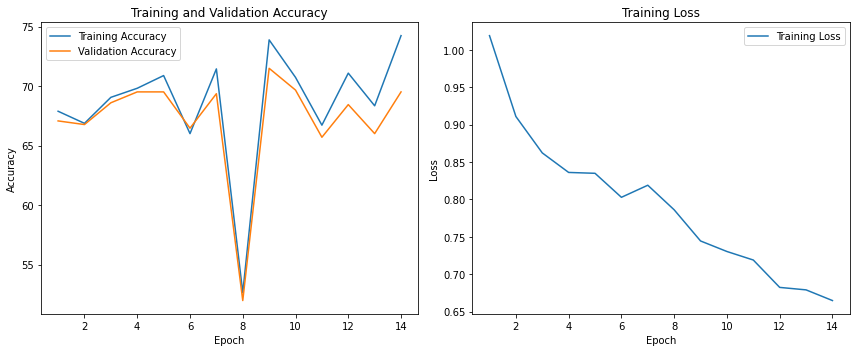

In [10]:

def evaluate_model(model, loader):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])  # Ensure 4x4 matrix
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, acc, f1
# Test the model
model.eval()
cm_all, acc_all, f1_all = evaluate_model(model, test_loader)
cm_mono, acc_mono, f1_mono = evaluate_model(model, test_loader_mono)
cm_poly, acc_poly, f1_poly = evaluate_model(model, test_loader_poly)

# Print results
print('All Test Cells:')
print('Confusion Matrix:')
print(cm_all)
print(f'Accuracy: {acc_all:.2f}')
print(f'F1 Score: {f1_all:.2f}')

print('\nMonocrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_mono)
print(f'Accuracy: {acc_mono:.2f}')
print(f'F1 Score: {f1_mono:.2f}')

print('\nPolycrystalline Test Cells:')
print('Confusion Matrix:')
print(cm_poly)
print(f'Accuracy: {acc_poly:.2f}')
print(f'F1 Score: {f1_poly:.2f}')

epochs = range(1, len(train_acc_history) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, test_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()